Cell 1: Activation cell

In [1]:
import sys
from pathlib import Path
import os

# --- Resolve project root safely from a notebook ---
PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Add project root to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

# --- Imports from src ---
from src.train import train_model

# --- Data directory ---
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "EuroSAT_RGB"
print("Data dir:", DATA_DIR)

# --- Train model ---
model, class_names = train_model(
    data_dir=DATA_DIR,
    epochs=5
)

Project root: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model
Data dir: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\data\raw\EuroSAT_RGB
Using device: cpu


Epoch 1/5: 100%|██████████| 296/296 [00:50<00:00,  5.81it/s]


Epoch 1 | Train Loss: 0.9459 | Val Acc: 0.7627
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn.pth (val_acc=0.7627)


Epoch 2/5: 100%|██████████| 296/296 [00:48<00:00,  6.09it/s]


Epoch 2 | Train Loss: 0.6562 | Val Acc: 0.7353


Epoch 3/5: 100%|██████████| 296/296 [00:50<00:00,  5.89it/s]


Epoch 3 | Train Loss: 0.5829 | Val Acc: 0.7437


Epoch 4/5: 100%|██████████| 296/296 [00:57<00:00,  5.18it/s]


Epoch 4 | Train Loss: 0.5326 | Val Acc: 0.7143


Epoch 5/5: 100%|██████████| 296/296 [01:08<00:00,  4.33it/s]


Epoch 5 | Train Loss: 0.4881 | Val Acc: 0.8309
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\simple_cnn.pth (val_acc=0.8309)
Done. Best Val Acc: 0.8309


Cell 2: Load saved model and run test evaluation

In [5]:
import torch
from pathlib import Path

from src.dataset import load_eurosat_dataset
from src.models import build_model
from src.eval import evaluate_model

device = "cuda" if torch.cuda.is_available() else "cpu"

# Reload loaders (same splits as before if seed is same)
train_loader, val_loader, test_loader, class_names = load_eurosat_dataset(
    data_dir=DATA_DIR,
    img_size=64,
    batch_size=64,
    seed=42
)

# Load model weights
model = build_model(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load(Path("../models/simple_cnn.pth"), map_location=device))
model.eval()

test_acc, cm, report = evaluate_model(model, test_loader, class_names, device)

print("Test Accuracy:", round(test_acc, 4))
print(report)

Test Accuracy: 0.8326
                      precision    recall  f1-score   support

          AnnualCrop     0.8684    0.8665    0.8674       472
              Forest     0.8548    0.9593    0.9041       442
HerbaceousVegetation     0.6793    0.9017    0.7749       458
             Highway     0.7414    0.7187    0.7299       391
          Industrial     0.8864    0.9497    0.9170       378
             Pasture     0.8406    0.7759    0.8070       299
       PermanentCrop     0.8005    0.7731    0.7866       379
         Residential     0.9000    0.9400    0.9196       450
               River     0.8862    0.5813    0.7021       375
             SeaLake     0.9610    0.7882    0.8660       406

            accuracy                         0.8326      4050
           macro avg     0.8419    0.8254    0.8274      4050
        weighted avg     0.8410    0.8326    0.8306      4050



Cell 3: Confusion matrix

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_baseline.png


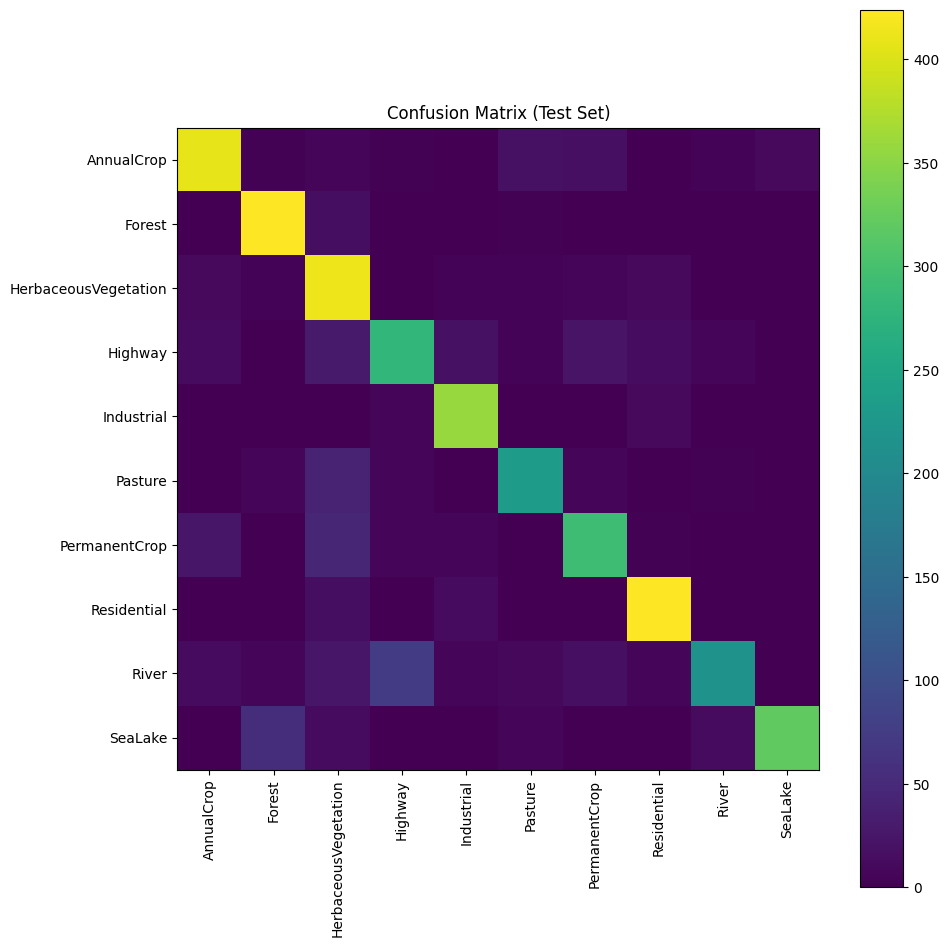

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(10, 10))
plt.imshow(cm)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()
plt.tight_layout()

out_path = fig_dir / "confusion_matrix_baseline.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

plt.show()